In [1]:
# 📦 1. Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración general de estilo
sns.set(style="whitegrid")
%matplotlib inline


In [ ]:
# 📥 2. Carga del dataset
df = pd.read_csv("../src/data/raw/hotel_bookings.csv")
df.shape, df.columns


FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/hotel_bookings.csv'

In [18]:
# 🔍 3. Información general y valores faltantes
df.info()
df.isnull().sum().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

company                           112593
agent                              16340
country                              488
children                               4
arrival_date_month                     0
arrival_date_week_number               0
hotel                                  0
is_canceled                            0
stays_in_weekend_nights                0
arrival_date_day_of_month              0
adults                                 0
stays_in_week_nights                   0
babies                                 0
meal                                   0
lead_time                              0
arrival_date_year                      0
distribution_channel                   0
market_segment                         0
previous_bookings_not_canceled         0
is_repeated_guest                      0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
previous_cancellations                 0
deposit_type    

In [19]:
# 🧼 4. Limpieza básica
# Llenamos children y country si es necesario
df["children"].fillna(0, inplace=True)
df.dropna(subset=["country"], inplace=True)

# Comprobamos de nuevo
df.isnull().sum()


C:\Users\user\AppData\Local\Temp\ipykernel_5648\3830914441.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["children"].fillna(0, inplace=True)


hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               0
babies                                 0
meal                                   0
country                                0
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16006
company         

Tasa de cancelación: 37.14%


Text(0.5, 1.0, 'Cancelaciones por tipo de hotel')

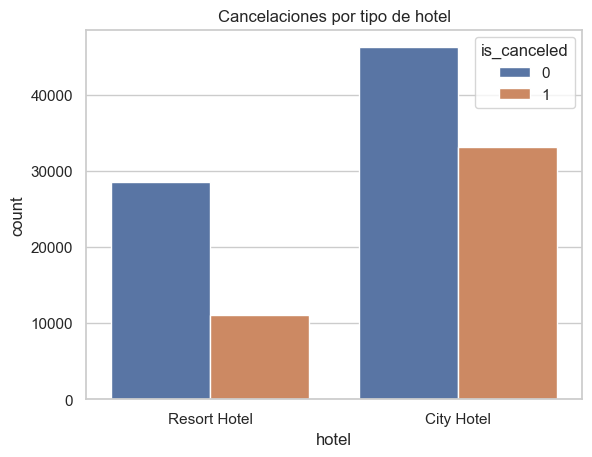

In [20]:
# 📊 5. Exploración básica
# ¿Cuál es la tasa de cancelación?
cancel_rate = df["is_canceled"].mean()
print(f"Tasa de cancelación: {cancel_rate:.2%}")

# Cancelaciones por tipo de hotel
sns.countplot(data=df, x="hotel", hue="is_canceled")
plt.title("Cancelaciones por tipo de hotel")


Text(0.5, 1.0, 'Distribución de noches de estadía')

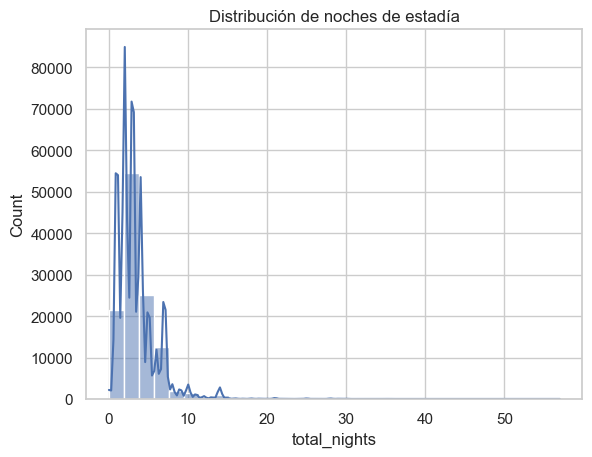

In [21]:
# 📈 6. Distribuciones y correlaciones
# Duración de la estadía total
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

sns.histplot(df["total_nights"], bins=30, kde=True)
plt.title("Distribución de noches de estadía")


In [22]:
# 📌 7. Selección de variables numéricas para clusterización
variables = [
    "lead_time",
    "total_nights",
    "adults",
    "children",
    "babies",
    "previous_cancellations",
    "booking_changes",
    "adr",  # average daily rate
]

X = df[variables].copy()

# Reemplazar posibles valores nulos
X.fillna(0, inplace=True)


In [23]:
# 📌 1. Crear variables numéricas para clusterización
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]
features = [
    "lead_time", "total_nights", "adults", "children",
    "babies", "previous_cancellations", "booking_changes", "adr"
]
X = df[features].fillna(0)


In [24]:
# ⚖️ 2. Escalar las variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [25]:
# 🔢 3. Clustering con KMeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)


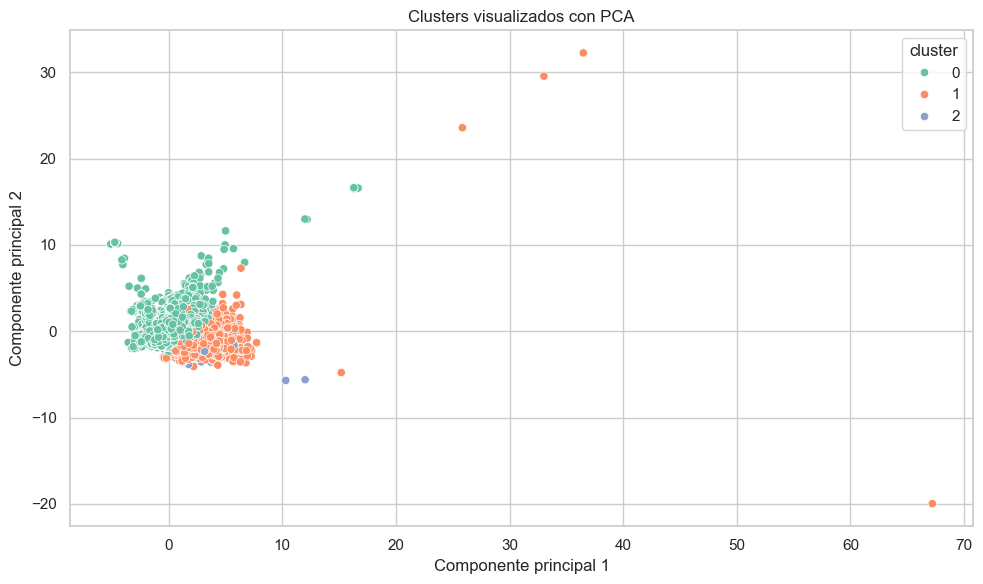

In [26]:
# 📉 4. Visualización con PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="cluster", palette="Set2")
plt.title("Clusters visualizados con PCA")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
# Promedio de cada variable por cluster
cluster_profiles = df.groupby("cluster")[[
    "lead_time", "total_nights", "adults", "children",
    "babies", "previous_cancellations", "booking_changes", "adr"
]].mean().round(2)

cluster_profiles


,lead_time,total_nights,adults,children,babies,previous_cancellations,booking_changes,adr
cluster,,,,,,,,
0,105.60,3.39,1.85,0.00,0.00,0.09,0.21,97.42
1,90.30,3.94,1.98,1.45,0.00,0.01,0.35,160.23
2,77.62,4.16,1.99,0.23,1.03,0.01,0.88,119.69


In [28]:
# Porcentaje de cancelaciones por cluster
df.groupby("cluster")["is_canceled"].mean().round(2)


cluster
0    0.37
1    0.37
2    0.18
Name: is_canceled, dtype: float64

In [29]:
df["cluster"].value_counts()


cluster
0    109634
1      8354
2       914
Name: count, dtype: int64

In [30]:
import joblib
import os

# Asignar nombres a los clusters
cluster_map = {
    0: "Reservas anticipadas de adultos",
    1: "Viajes familiares con planificación media",
    2: "Reservas especiales y confiables"
}
df["cluster_nombre"] = df["cluster"].map(cluster_map)

# Guardar el modelo entrenado
os.makedirs("models", exist_ok=True)
joblib.dump(kmeans, "../src/model/modelo_clusters_kmeans.pkl")
print("✅ Modelo guardado en models/modelo_clusters_kmeans.pkl")


FileNotFoundError: [Errno 2] No such file or directory: 'src/model/modelo_clusters_kmeans.pkl'